# Rolling ball filter

- https://media.nature.com/original/nature-assets/srep/2016/160725/srep30179/extref/srep30179-s1.pdf
- https://github.com/imagej/imagej1/blob/master/ij/plugin/filter/BackgroundSubtracter.java
- http://ieeexplore.ieee.org/document/1654163/?reload=true

https://plot.ly/python/alpha-shapes/
>In a family of alpha shapes, the parameter α controls the level of detail of the associated alpha shape. If α decreases to zero, the corresponding alpha shape degenerates to the point set, S, while if it tends to infinity the alpha shape tends to the convex hull of the set S.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial

In [2]:
# %load rolling_ball.py
#!/usr/bin/env python
# rolling_ball.py
"""
Rolling ball filter

References

- https://media.nature.com/original/nature-assets/srep/2016/160725/srep30179/extref/srep30179-s1.pdf
- https://github.com/imagej/imagej1/blob/master/ij/plugin/filter/BackgroundSubtracter.java
- http://ieeexplore.ieee.org/document/1654163/?reload=true

https://plot.ly/python/alpha-shapes/
In a family of alpha shapes, the parameter α controls the level of detail of the associated alpha shape.
If α decreases to zero, the corresponding alpha shape degenerates to the point set, S, while if it tends to
infinity the alpha shape tends to the convex hull of the set S.


Copyright (c) 2018, David Hoffman
"""

import numpy as np
from scipy import spatial
from scipy import interpolate


def sq_norm(v):
    """squared norm"""
    return (v**2).sum(0)


def circumcircle(points, simplex):
    """Get the circumcenter and circum radius of all the simplices, works for 2D only

    Compute the circumcenter and circumradius of a triangle (see their definitions
    https://en.wikipedia.org/wiki/Circumscribed_circle#Circumcircle_equations)

    http://mathworld.wolfram.com/Circumcircle.html"""
    d = len(simplex)
    A = [points[k] for k in simplex]
    M = [[1.0] * (d + 1)]
    M += [[sq_norm(A[k]), A[k][0], A[k][1], 1.0] for k in range(d)]
    M = np.asarray(M, dtype=float)
    # M is equation (2) at mathworld
    # eq. (4)
    a = np.linalg.det(M[1:, 1:])
    # bx is (6)
    bx = -np.linalg.det(M[1:, [0, 2, 3]])
    # by is (7)
    by = np.linalg.det(M[1:, [0, 1, 3]])
    # eq. (8)
    c = -np.linalg.det(M[1:, :-1])
    # eqns. (11) and (12)
    center = np.array([-bx, -by]) / a / 2
    # eqn. (13)
    radius = np.sqrt(sq_norm(center) - c / a)
    return center, radius


def get_alpha_complex(alpha, points, simplices):
    # find the centers and radii of all circumcircles
    centers, radii = np.array([circumcircle(points, s) for s in simplices]).T
    # convert centers to array
    centers = np.vstack(centers)
    # find which points you want to keep
    to_keep = radii > alpha
    alpha_complex = points[simplices[to_keep]]
    # calculate where the center of the circle lies with respect to the vertices
    above_right = alpha_complex > centers[to_keep][:, None]
    return alpha_complex, above_right


def rolling_ball_filter(data, ball_radius, roll_along=-1, top=True,
                        interpolator=interpolate.interp1d, nn=1, **kwargs):
    """Rolling ball filter
    
    Parameters
    ----------
    data : ndarray (n, d)
        Array of data points, assumed xyz ordering
    ball_radius : float
        The size of the ball to roll
    roll_along : int
        The axis perpendicular to the roll direction
    top : bool
        Top or bottom
    interpolator : callable
        needs to take two arrays and return a callable
    kwargs : for interpolator
    
    Returns
    -------
    data : ndarray (n, d)
        Smoothed data"""
    n, d = data.shape
    tri = spatial.Delaunay(data)
    alpha_complex, above_right = get_alpha_complex(ball_radius, tri.points, tri.simplices)
    # calculate the ball rolling from the right
    # sum along vertices and direction, determine if more than one vertex is
    kept_points = above_right.sum(1)[:, roll_along] > nn
    if top:
        kept_points = ~kept_points
    d_kept = np.unique(alpha_complex[kept_points].reshape(-1, d), axis=0)
    x, y = data.T
    X, Y = d_kept.T
    interp = interpolator(X, Y, **kwargs)
    return x, interp(x)


# if __name__ == '__main__':
#     # import plotting
#     import matplotlib.pyplot as plt
#     # remove randomness
#     np.random.seed(42)
#     # generate toy data
#     x = np.linspace(-2 * np.pi, 2 * np.pi, 256)
#     y = np.sin(10 * x)
#     y *= np.exp(-2 * x**2)
#     y += np.poly1d(np.random.randn(3))(x) * 0.01

#     ball_r = 0.5
#     X_top, Y_top = rolling_ball_filter(np.array((x, y)).T, ball_r)
#     X_bottom, Y_bottom = rolling_ball_filter(np.array((x, y)).T, ball_r, top=False)

#     fig, ax = plt.subplots()
#     ax.plot(x, y, label="Data")
#     ax.plot(X_top, Y_top, label="Rolled on top")
#     ax.plot(X_bottom, Y_bottom, label="Rolled on bottom")
#     ax.legend()
#     ax.set_title("Rolling ball filter with radius = {}".format(ball_r))

#     plt.show()


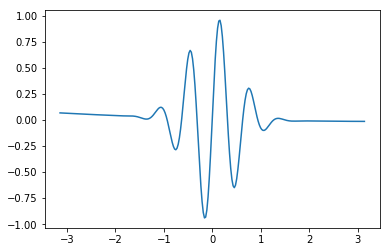

In [3]:
x= np.linspace(-1 * np.pi, 1 * np.pi, 256)
y = np.sin(10 * x)
y *= np.exp(-2 * x**2)
y += np.poly1d(np.random.randn(3))(x) * 0.01
plt.plot(x, y)

In [4]:
from matplotlib.patches import Circle

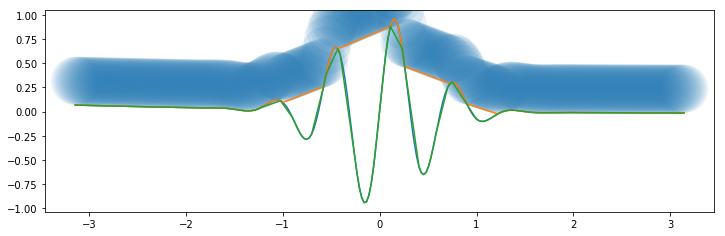

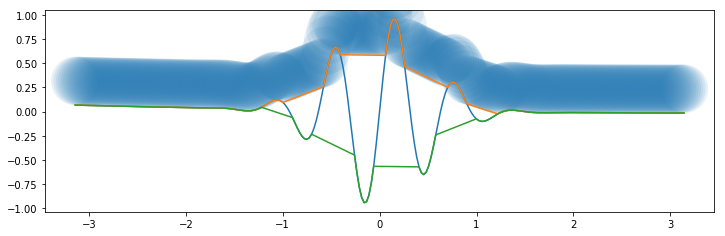

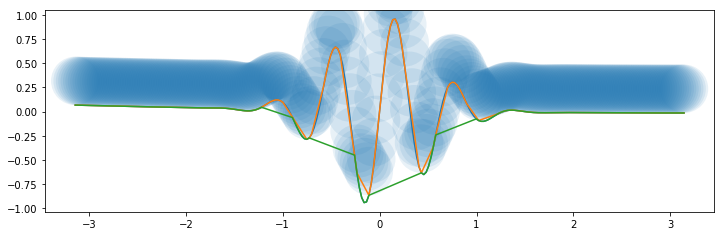

In [5]:
for nn in (0,1,2):
    r = 0.25
    X, Y = rolling_ball_filter(np.array((x, y)).T, r, nn=nn, kind=1)
    Xb, Yb = rolling_ball_filter(np.array((x, y)).T, r, top=False, nn=nn, kind=1)

    # the complement of rolling above is below
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.set_aspect(1)
    ax.plot(x, y)
    ax.plot(X, Y)
    ax.plot(Xb, Yb)
    for xx, yy in zip(X, Y):
        c = Circle((xx, yy + r), radius=r,alpha=0.1)
        ax.add_patch(c)
    X.shape

(256,)

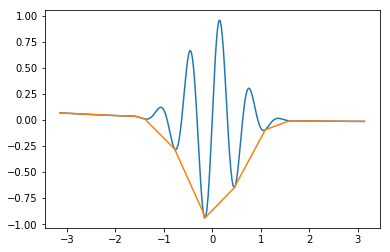

In [6]:
X, Y = rolling_ball_filter(np.array((x, y)).T, 1, top=False, kind=1)

# the complement of rolling above is below
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(X, Y)
X.shape

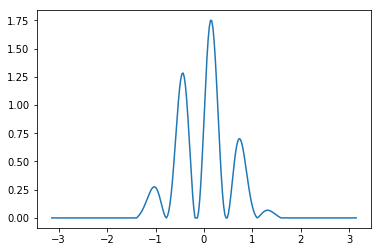

In [7]:
plt.plot(X, y-Y)